In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import interpolate
import matplotlib.pyplot as plt
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        #encoder
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = self.crop_and_concat(xu1, xe42)
        #xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = self.crop_and_concat(xu2, xe32)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = self.crop_and_concat(xu3, xe22)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = self.crop_and_concat(xu4, xe12)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        out = interpolate(out, size = x.shape[2:], mode ='bilinear', align_corners=True)
        return out
    
    
    def crop_and_concat(self, upsampled, bypass):
        _, _, H, W = upsampled.size()
        bypass = interpolate(bypass, size=(H, W), mode='bilinear', align_corners=True)
        return torch.cat((upsampled, bypass), dim=1)


In [3]:
with h5py.File('/kaggle/input/med-imaging-new-dataset/mydata8.h5', 'r') as file:
     data = np.array(file['DS1'])

In [4]:
data = data.astype('float32')

In [5]:
noisy_data1 = data[0]
noisy_data = noisy_data1/(np.max(noisy_data1))
clean_data1 = data[1]
clean_data = clean_data1/(np.max(clean_data1))

Text(0.5, 1.0, 'Difference')

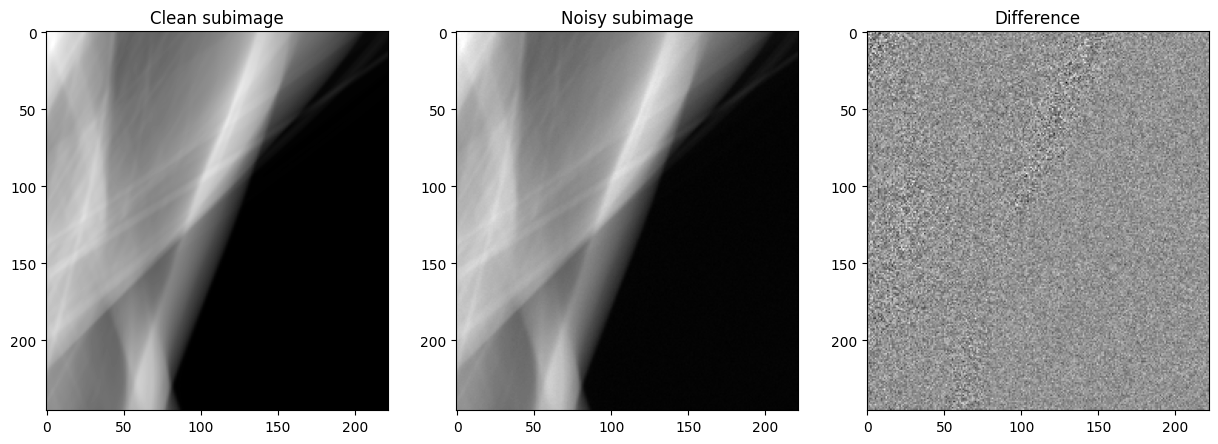

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.imshow(data[1][521], cmap = 'gray')
plt.title('Clean subimage')
plt.subplot(1,3,2)
plt.imshow(data[0][521], cmap = 'gray')
plt.title('Noisy subimage')
plt.subplot(1,3,3)
plt.imshow(data[0][521]-data[1][521],cmap = 'gray')
plt.title('Difference')

In [7]:

X_train, X_val, y_train, y_val = train_test_split(noisy_data, clean_data, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=1)
y_train = np.expand_dims(y_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
y_val = np.expand_dims(y_val, axis=1)


X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val)



In [8]:

class ImageDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = noisy_data
        self.clean_data = clean_data

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.clean_data[idx]

train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
model = UNet(1)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for noisy_data, clean_data in train_loader:
        noisy_data, clean_data = noisy_data.to(device), clean_data.to(device)

        outputs = model(noisy_data)
        loss = criterion(outputs, clean_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * noisy_data.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.8f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy_data, clean_data in val_loader:
            noisy_data, clean_data = noisy_data.to(device), clean_data.to(device)

            outputs = model(noisy_data)
            loss = criterion(outputs, clean_data)

            val_loss += loss.item() * noisy_data.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.8f}")

# Save the model
torch.save(model.state_dict(), 'unet_denoising_model_2.pth')

Epoch [1/25], Loss: 0.00127072
Validation Loss: 0.00001843
Epoch [2/25], Loss: 0.00001888
Validation Loss: 0.00059552
Epoch [3/25], Loss: 0.00004978
Validation Loss: 0.00000754
Epoch [4/25], Loss: 0.00000648
Validation Loss: 0.00000581
Epoch [5/25], Loss: 0.00000477
Validation Loss: 0.00000416
Epoch [6/25], Loss: 0.00001099
Validation Loss: 0.00000443
Epoch [7/25], Loss: 0.00000409
Validation Loss: 0.00000591
Epoch [8/25], Loss: 0.00001093
Validation Loss: 0.00001426
Epoch [9/25], Loss: 0.00002257
Validation Loss: 0.00001155
Epoch [10/25], Loss: 0.00020748
Validation Loss: 0.00000477
Epoch [11/25], Loss: 0.00000419
Validation Loss: 0.00000363
Epoch [12/25], Loss: 0.00000333
Validation Loss: 0.00000285
Epoch [13/25], Loss: 0.00000246
Validation Loss: 0.00000205
Epoch [14/25], Loss: 0.00000184
Validation Loss: 0.00000167
Epoch [15/25], Loss: 0.00000158
Validation Loss: 0.00000144
Epoch [16/25], Loss: 0.00000150
Validation Loss: 0.00000138
Epoch [17/25], Loss: 0.00000138
Validation Loss: 

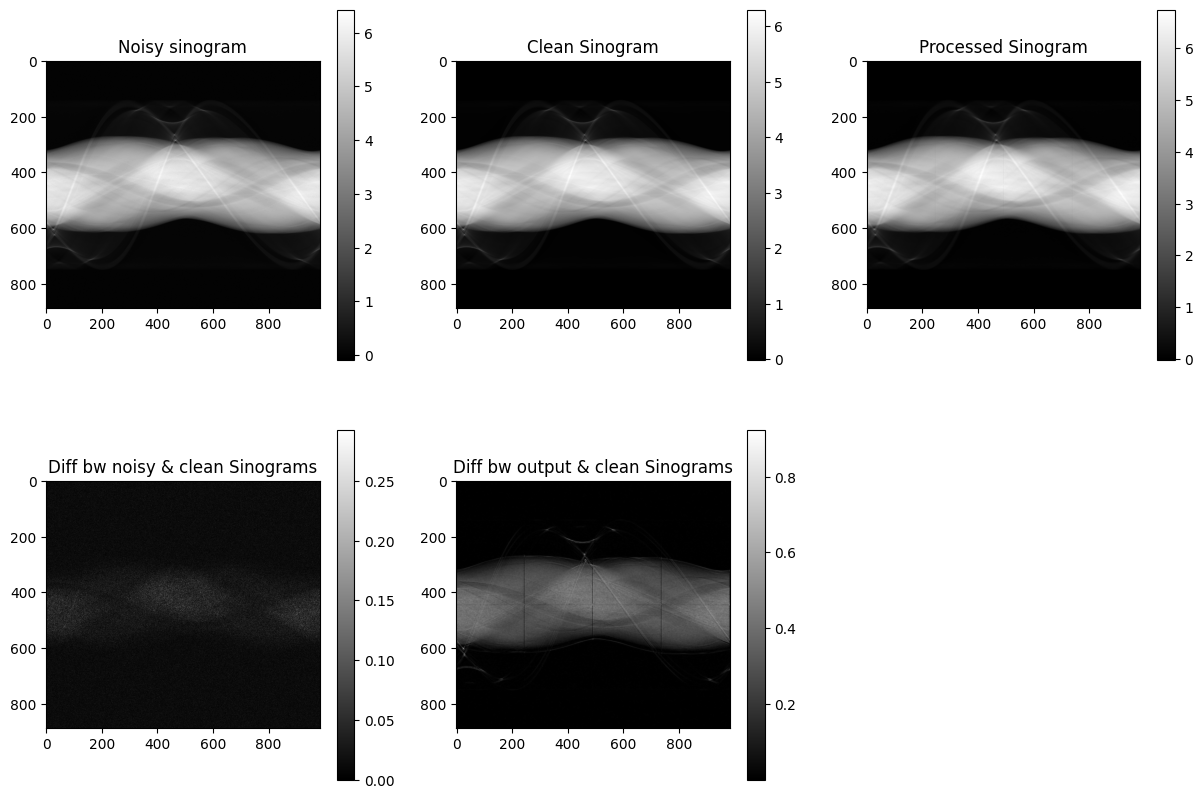

In [12]:

def process_large_image_with_model(image, model, device, sub_image_size=(246, 222)):
    
    def divide_image(image, sub_image_size):
        sub_images = []
        k = 0
        for i in range(4):
            for j in range(4):
                start_row = i * sub_image_size[0]
                end_row = (i + 1) * sub_image_size[0]
                start_col = j * sub_image_size[1]
                end_col = (j + 1) * sub_image_size[1]
                sub_image = image[start_row:end_row, start_col:end_col]
                sub_images.append(sub_image)
                k += 1
        return sub_images

    def combine_sub_images(sub_images, original_size, sub_image_size):
        combined_image = np.zeros(original_size)
        k = 0
        for i in range(4):
            for j in range(4):
                start_row = i * sub_image_size[0]
                end_row = (i + 1) * sub_image_size[0]
                start_col = j * sub_image_size[1]
                end_col = (j + 1) * sub_image_size[1]
                combined_image[start_row:end_row, start_col:end_col] = sub_images[k]
                k += 1
        return combined_image

    sub_images = divide_image(image, sub_image_size)
    
    processed_sub_images = []
    model.eval() 
    for sub_image in sub_images:
        sub_image_tensor = torch.tensor(sub_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            output_tensor = model(sub_image_tensor)
        processed_sub_image = output_tensor.squeeze().cpu().numpy()
        processed_sub_images.append(processed_sub_image)
    
    output_image = combine_sub_images(processed_sub_images, image.shape, sub_image_size)
    return output_image

h5_file_path = '/kaggle/input/med-imaging-noisysino-dataset1/mydata9.h5'  # Replace with the path to your HDF5 file
h5_dataset_name = 'DS1'  # Replace with the dataset name within the HDF5 file

with h5py.File(h5_file_path, 'r') as h5_file:
    image1 = np.array(h5_file[h5_dataset_name])
x = np.random.randint(0,407)
image = image1[0,x,:,:]
image_original = image1[1,x,:,:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_path = '/kaggle/input/med-imaging-denoising-model1/unet_denoising_model.pth'  # Path to your saved model
model = UNet(n_class=1).to(device)
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)


# Process the image
output_image = process_large_image_with_model(image, model, device)

# Display the result
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.title('Noisy sinogram')
noisy_sinogram_plot = plt.imshow(np.rot90(image,k=-1), cmap='gray')
plt.colorbar(noisy_sinogram_plot, orientation='vertical')
plt.axis('image')

plt.subplot(2, 3, 2)
plt.title('Clean Sinogram')
clean_image_plot = plt.imshow(np.rot90(image_original,k=-1), cmap='gray')
plt.colorbar(clean_image_plot, orientation='vertical')
plt.axis('image')

plt.subplot(2, 3, 3)
plt.title('Processed Sinogram')
processed_image_plot = plt.imshow(np.rot90(output_image,k=-1), cmap='gray')
plt.colorbar(processed_image_plot, orientation='vertical')
plt.axis('image')

plt.subplot(2, 3, 4)
plt.title('Diff bw noisy & clean Sinograms')
diff_noisy_clean_plot = plt.imshow(np.abs(np.rot90(image,k=-1) - np.rot90(image_original,k=-1)), cmap='gray')
plt.colorbar(diff_noisy_clean_plot, orientation='vertical')
plt.axis('image')

plt.subplot(2, 3, 5)
plt.title('Diff bw output & clean Sinograms')
diff_processed_clean_plot = plt.imshow(np.abs(np.rot90(output_image,k=-1) - np.rot90(image_original,k=-1)), cmap='gray')
plt.colorbar(diff_processed_clean_plot, orientation='vertical')
plt.axis('image')

plt.show()